<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 2. Image Classification of an American Sign Language Dataset

In this section, we will perform the data preparation, model creation, and model training steps we observed in the last section using a different dataset: images of hands making letters in [American Sign Language](http://www.asl.gs/).

## 2.1 Objectives

* Prepare image data for training
* Create and compile a simple model for image classification
* Train an image classification model and observe the results

In [2]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

## 2.2 American Sign Language Dataset

The [American Sign Language alphabet](http://www.asl.gs/) contains 26 letters. Two of those letters (j and z) require movement, so they are not included in the training dataset.  

<img src="./images/asl.png" style="width: 600px;">

### 2.2.1 Kaggle

This dataset is available from the website [Kaggle](http://www.kaggle.com), which is a fantastic place to find datasets and other deep learning resources. In addition to providing resources like datasets and "kernels" that are like these notebooks, Kaggle hosts competitions that you can take part in, competing with others in training highly accurate models.

If you're looking to practice or see examples of many deep learning projects, Kaggle is a great site to visit.

## 2.3 Loading the Data

This dataset is not available via TorchVision in the same way that MNIST is, so let's learn how to load custom data. By the end of this section we will have `x_train`, `y_train`, `x_valid`, and `y_valid` variables.

### 2.3.1 Reading in the Data

The sign language dataset is in [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) (Comma Separated Values) format, the same data structure behind Microsoft Excel and Google Sheets. It is a grid of rows and columns with labels at the top, as seen in the [train](data/asl_data/sign_mnist_train.csv) and [valid](data/asl_data/sign_mnist_valid.csv) datasets (they may take a moment to load).

To load and work with the data, we'll be using a library called [Pandas](https://pandas.pydata.org/), which is a highly performant tool for loading and manipulating data. We'll read the CSV files into a format called a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

Pandas has a [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method that expects a csv file, and returns a DataFrame:

In [3]:
train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

### 2.3.2 Exploring the Data

Let's take a look at our data. We can use the [head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method to print the first few rows of the DataFrame. Each row is an image which has a `label` column, and also, 784 values representing each pixel value in the image, just like with the MNIST dataset. Note that the labels currently are numerical values, not letters of the alphabet:

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### 2.3.3 Extracting the Labels

Let's store our training and validation labels in `y_train` and `y_valid` variables. We can use the [pop](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pop.html) method to remove a column from our DataFrame and assign the removed values to a variable.

In [5]:
y_train = train_df.pop('label')
y_valid = valid_df.pop('label')
y_train

0         3
1         6
2         2
3         2
4        12
         ..
27450    12
27451    22
27452    17
27453    16
27454    22
Name: label, Length: 27455, dtype: int64

### 2.3.4 Extracting the Images

Next, let's store our training and validation images in `x_train` and `x_valid` variables. Here we create those variables:

In [6]:
x_train = train_df.values
x_valid = valid_df.values
x_train

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       ...,
       [174, 174, 174, ..., 202, 200, 200],
       [177, 181, 184, ...,  64,  87,  93],
       [179, 180, 180, ..., 205, 209, 215]], shape=(27455, 784))

### 2.3.5 Summarizing the Training and Validation Data

We now have 27,455 images with 784 pixels each for training...

In [7]:
x_train.shape

(27455, 784)

...as well as their corresponding labels:

In [8]:
y_train.shape

(27455,)

For validation, we have 7,172 images...

In [9]:
x_valid.shape

(7172, 784)

...and their corresponding labels:

In [10]:
y_valid.shape

(7172,)

## 2.4 Visualizing the Data

To visualize the images, we will again use the matplotlib library. We don't need to worry about the details of this visualization, but if interested, you can learn more about [matplotlib](https://matplotlib.org/) at a later time.

Note that we'll have to reshape the data from its current 1D shape of 784 pixels, to a 2D shape of 28x28 pixels to make sense of the image:

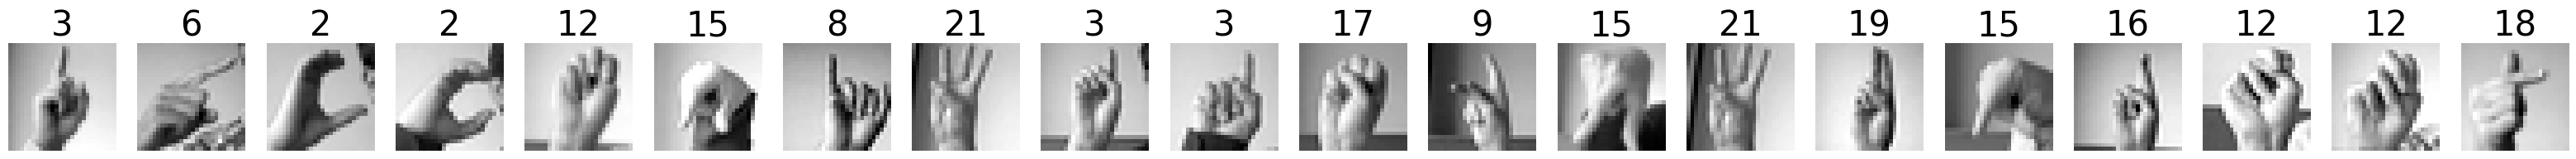

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))

num_images = 20
for i in range(num_images):
    row = x_train[i]
    label = y_train[i]

    image = row.reshape(28,28)
    plt.subplot(1, num_images, i+1)
    plt.title(label, fontdict={'fontsize': 30})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

### 2.4.1 Normalize the Image Data

As we did with the MNIST dataset, we are going to normalize the image data, meaning that their pixel values, instead of being between 0 and 255 as they are currently:

In [12]:
x_train.min()

np.int64(0)

In [13]:
x_train.max()

np.int64(255)

In the previous lab, we used [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html), but we can also modify our data before turning it into a tensor.

In [14]:
x_train = train_df.values / 255
x_valid = valid_df.values / 255

### 2.4.2 Custom Datasets

We can use PyTorch's [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) tools in order to create our own dataset. `__init__` will run once when the class is initialized. `__getitem__` returns our images and labels.

Since our dataset is small enough, we can store it on our GPU for faster processing. In the previous lab, we sent our data to the GPU when it was drawn from each batch. Here, we will send it to the GPU in the `__init__` function.

In [15]:
class MyDataset(Dataset):
    def __init__(self, x_df, y_df):
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

A custom PyTorch dataset works just like a prebuilt one. It should be passed to a [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) for model training.

In [16]:
BATCH_SIZE = 32

train_data = MyDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader.dataset)

In [17]:
valid_data = MyDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

We can verify the DataLoader works as expected with the code below. We'll make the DataLoader [iterable](https://docs.python.org/3/library/functions.html#iter), and then call [next](https://docs.python.org/3/library/functions.html#next) to draw the first hand from the deck.

In [18]:
train_loader

Try running the below a few times. The values should change each time.

In [19]:
batch = next(iter(train_loader))
batch

[tensor([[0.3843, 0.2784, 0.4902,  ..., 0.3608, 0.3647, 0.3647],
         [0.3412, 0.3843, 0.2078,  ..., 0.2667, 0.3020, 0.2941],
         [0.4902, 0.5059, 0.5216,  ..., 0.3216, 0.2627, 0.3569],
         ...,
         [0.6314, 0.6431, 0.6510,  ..., 0.5176, 0.5294, 0.6078],
         [0.4275, 0.4471, 0.4588,  ..., 0.0000, 0.0000, 0.0706],
         [0.6039, 0.6275, 0.6510,  ..., 0.6980, 0.6275, 0.3686]]),
 tensor([ 9, 15, 10, 20, 11, 11,  1,  8,  3,  5,  6, 14, 11, 21, 21,  7,  0,  7,
          1,  5, 14, 12, 21,  6, 10, 17,  7, 14, 11, 18,  4, 10])]

Notice the batch has two values. The first is our `x`, and the second is our `y`. The first dimension of each should have `32` values, which is the `batch_size`.

In [20]:
batch[0].shape

torch.Size([32, 784])

In [21]:
batch[1].shape

torch.Size([32])

## 2.5 Build the Model

We've created our DataLoaders, now it's time to build our models.

#### Exercise

For this exercise we are going to build a sequential model. Just like last time, build a model that:

* Has a flatten layer.
* Has a dense input layer. This layer should contain 512 neurons amd use the `relu` activation function
* Has a second dense layer with 512 neurons which uses the `relu` activation function
* Has a dense output layer with neurons equal to the number of classes

We will define a few variables to get started:

In [22]:
input_size = 28 * 28
n_classes = 24

Do your work in the cell below, creating a `model` variable to store the model. We've imported the [Sequental](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model class and [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer class to get you started. Reveal the solution below for a hint:

In [23]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
)

#### Solution

In [24]:
# SOLUTION
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
)

This time, we'll combine compiling the model and sending it to the GPU in one step:

In [25]:
model = torch.compile(model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=24, bias=True)
  )
)

Since categorizing these ASL images is similar to categorizing MNIST's handwritten digits, we will use the same `loss_function` ([Categorical CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and `optimizer` ([Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)).

In [26]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

## 2.6 Training the Model

This time, let's look at our `train` and `validate` functions in more detail.

### 2.6.1 The Train Function

This code is almost the same as in the previous notebook, but we no longer send `x` and `y` to our GPU because our DataLoader already does that.

Before looping through the DataLoader, we will set the model to [model.train](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train) to make sure its parameters can be updated. To make it easier for us to follow training progress, we'll keep track of the total `loss` and `accuracy`.

Then, for each batch in our `train_loader`, we will:
1. Get an `output` prediction from the model
2. Set the gradient to zero with the `optimizer`'s [zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) function
3. Calculate the loss with our `loss_function`
4. Compute the gradient with [backward](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html)
5. Update our model parameters with the `optimizer`'s [step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) function.
6. Update the `loss` and `accuracy` totals

In [2]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### 2.6.2 The Validate Function

The model does not learn during validation, so the `validate` function is simpler than the `train` function above.

One key difference is we will set the model to evaluation mode with [model.evaluate](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval), which will prevent the model from updating any parameters.

In [3]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### 2.6.3 Calculating the Accuracy

Both the `train` and `validate` functions use `get_batch_accuracy`, but we have not defined that in this notebook yet. 

#### Exercise

The function below has three `FIXME`s. Each one corresponds to the functions input arguments. Can you replace each FIXME with the correct argument?

It may help to view the documentation for [argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html), [eq](https://pytorch.org/docs/stable/generated/torch.eq.html), and [view_as](https://pytorch.org/docs/stable/generated/torch.Tensor.view_as.html).

In [4]:
def get_batch_accuracy(output, y, N):
    # .argmax returns the indices of the maximum value of all elements in the input tensor.
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

#### Solution

Click the `...` below for the solution.

In [5]:
# SOLUTION
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

### 2.6.3 The Training Loop

Let's bring it all together! Run the cell below to train the data for 20 `epochs`.

In [6]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0


NameError: name 'model' is not defined

### 2.6.4 Discussion: What happened?

We can see that the training accuracy got to a fairly high level, but the validation accuracy was not as high. What happened here?

Think about it for a bit before clicking on the '...' below to reveal the answer.

`# SOLUTION`
This is an example of the model learning to categorize the training data, but performing poorly against new data that it has not been trained on. Essentially, it is memorizing the dataset, but not gaining a robust and general understanding of the problem. This is a common issue called *overfitting*. We will discuss overfitting in the next two lectures, as well as some ways to address it.

## 2.7 Summary

In this section you built your own neural network to perform image classification that is quite accurate. Congrats!

At this point we should be getting somewhat familiar with the process of loading data (including labels), preparing it, creating a model, and then training the model with prepared data.

### Extra
#### Result
By running this code, you will see two plots:

Training and Validation Loss: This plot shows how the loss decreases over the epochs for both training and validation datasets.

Training and Validation Accuracy: This plot shows how the accuracy improves over the epochs for both training and validation datasets.

These plots help you visually understand the model's learning process and identify any overfitting or underfitting issues.

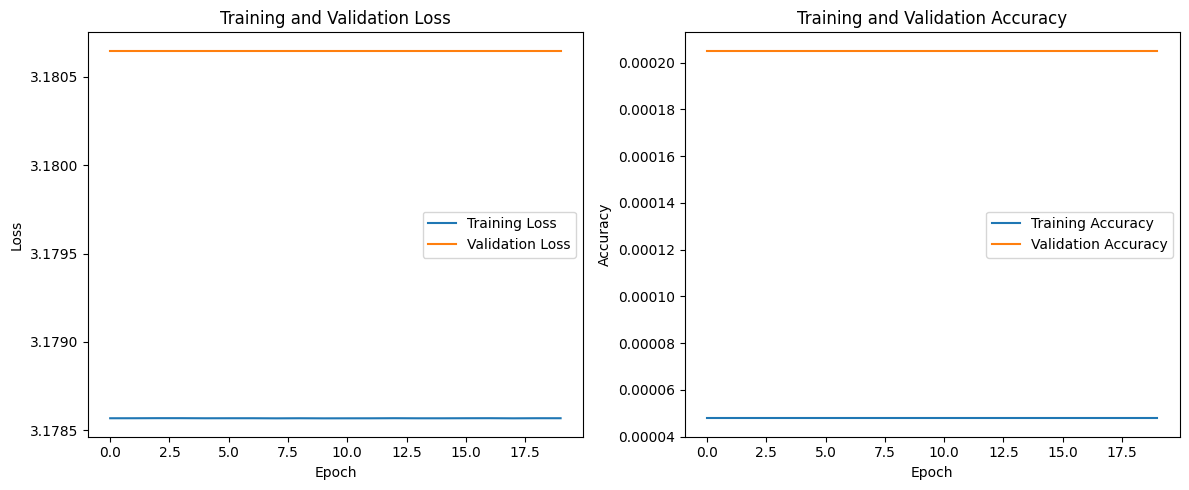

In [41]:
# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

def train():
    global train_losses, train_accuracies  # Make the lists accessible inside the function
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    
    # Average loss and accuracy over the batches
    train_losses.append(loss / len(train_loader))
    train_accuracies.append(accuracy / len(train_loader))

    # print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

def validate():
    global valid_losses, valid_accuracies  # Make the lists accessible inside the function
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    
    # Average loss and accuracy over the batches
    valid_losses.append(loss / len(valid_loader))
    valid_accuracies.append(accuracy / len(valid_loader))

    # print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

epochs = 20

for epoch in range(epochs):
    # print('Epoch: {}'.format(epoch))
    train()
    validate()

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(epochs), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Plot images and predictions

In [1]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Define the number of samples to pick
num_samples_to_pick = 10

# Set device (either 'cuda' if available or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the selected device
model.to(device)

# Randomly select indices
random_indices = random.sample(range(len(x_valid)), num_samples_to_pick)

# Extract the selected samples
selected_x_valid = x_valid[random_indices]
selected_y_valid = y_valid[random_indices]

# Convert selected_x_valid and selected_y_valid to torch tensors if they are not already
if isinstance(selected_x_valid, (torch.Tensor, np.ndarray)):
    selected_x_valid = torch.tensor(selected_x_valid) if not isinstance(selected_x_valid, torch.Tensor) else selected_x_valid
else:
    selected_x_valid = torch.tensor(selected_x_valid.to_numpy())  # Convert pandas DataFrame/Series to NumPy array and then to tensor

if isinstance(selected_y_valid, (torch.Tensor, np.ndarray)):
    selected_y_valid = torch.tensor(selected_y_valid) if not isinstance(selected_y_valid, torch.Tensor) else selected_y_valid
else:
    selected_y_valid = torch.tensor(selected_y_valid.to_numpy())  # Convert pandas DataFrame/Series to NumPy array and then to tensor

# Convert input data to float32 to match model's dtype
selected_x_valid = selected_x_valid.float()

# Move the selected data to the same device as the model
selected_x_valid = selected_x_valid.to(device)
selected_y_valid = selected_y_valid.to(device)

# Predict using the model
with torch.no_grad():
    output = model(selected_x_valid)
    predicted_labels = output.argmax(dim=1)

# Move data to CPU for visualization
selected_x_valid = selected_x_valid.cpu()
selected_y_valid = selected_y_valid.cpu()
predicted_labels = predicted_labels.cpu()

# Create a mapping from numeric labels to ASL letters
# !!! adjust the following code to drop letter 'J' and 'Z'
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"
asl_mapping = {i: chr(65 + i) for i in range(26) if chr(65 + i) not in ['J', 'Z']}

# Convert numeric labels to ASL string labels using the mapping
predicted_labels_str = [asl_mapping[label.item()] for label in predicted_labels]
actual_labels_str = [asl_mapping[label.item()] for label in selected_y_valid]

# Assume the original images were 28x28 pixels
image_size = (28, 28)

# Plot the images with their predicted and actual labels
plt.figure(figsize=(15, 5))

for i in range(num_samples_to_pick):
    plt.subplot(2, 5, i + 1)  # 2 rows and 5 columns
    image = selected_x_valid[i].numpy().reshape(image_size)  # Reshape back to original dimensions (28x28)
    plt.imshow(image, cmap='gray')  # Display image as grayscale
    plt.title(f'Pred: {predicted_labels_str[i]}, Actual: {actual_labels_str[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

### 2.7.1 Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory. This is required to move on to the next notebook.

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 2.7.2 Next

Now that you have built some very basic, somewhat effective models, we will begin to learn about more sophisticated models, including *Convolutional Neural Networks*.

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>